<h2><center>Project - Optimization with Applications-1</center></h2>
<h5><center>Anand Prakash Saini</center></h5>
<h6><center>September 6, 2023</center></h6>

**Objective:**
Explore compressed sensing: We aim to solve the optimization problem using Lasso regression to find the sparsest vector, Alpha. We then aim to use this methodology for image reconstruction.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.metrics import mean_squared_error
from skimage import data, color, transform, feature
from skimage.io import imshow
import warnings
warnings.filterwarnings('ignore')

**1. Recover the Sparse vector**

Let $\alpha$ be a sparse vector of size $N$ with $s$ non-zero entries. Take a random square Gaussian matrix $X$ and compute the noiseless transformation $y = X \alpha$.

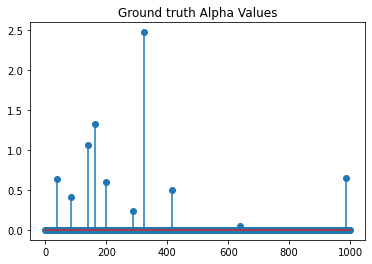

In [28]:
N = 1000    # Size of the sparse vector, Alpha
s = 10      # Non-zero entries in Alpha
alpha = np.zeros(N) 
non_zero_indices = np.random.choice(alpha.shape[0], s, replace = False)
alpha[non_zero_indices] = np.abs(np.random.randn(s))

X = np.random.randn(N,N)        # Random square gausian matrix of size(N,N)
y = X @ alpha                   # Noiseless Transformation y = Xα

plt.stem(alpha)
plt.title('Ground truth Alpha Values')
plt.show()

Now take a subsample $X_{n}$ of $X$ corresponding to $n$ randomly chosen rows and solve the problem:
<h3><center>$ \textrm{min}_{\alpha} \lVert \alpha \rVert_{1} \textrm{s.t.} y_{n} = X_{n}\alpha$</center></h3>

Compare the minimizing $\alpha$ to the true one.

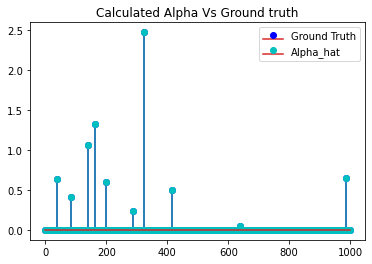

In [29]:
# Now take a subsample Xn of X corresponding to n randomly chosen rows:
n = 200     # For subsampling: total number of rows for indexing
total_rows = X.shape[0]
random_indices = np.random.choice(total_rows, size=n, replace=False)  # Indices
X_n = X[random_indices, :]      # Selecting random rows from X_n
y_n = y[random_indices]         # Selecting random rows from y_n


# Solving the minimization problem
alpha_hat = cp.Variable(N)

objective = cp.Minimize(cp.norm1(alpha_hat))

constraints = [y_n == X_n @ alpha_hat ]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()
    
alpha_hat = alpha_hat.value

plt.title('Calculated Alpha Vs Ground truth')
plt.stem(alpha, markerfmt='bo', label = 'Ground Truth')
plt.stem(alpha_hat, markerfmt='co', label = 'Alpha_hat')
plt.legend()
plt.show()

In [30]:
print('Mean Squared Error for ground truth alpha and calculated alpha (alpha_hat):' , mean_squared_error(alpha,alpha_hat))

Mean Squared Error for ground truth alpha and calculated alpha (alpha_hat): 1.123402393751329e-23


Estimate the probability of recovering the correct support by running this experiment multiple times.

In [33]:
def recover_prob_function(N, s, n, num_exp):
    recover_prob = []
    for i in range(num_exp):
        alpha = np.zeros(N) 
        non_zero_indices = np.random.choice(alpha.shape[0], s, replace = False)
        alpha[non_zero_indices] = np.abs(np.random.randn(s))

        X = np.random.randn(N,N)        # Random square gausian matrix of size(N,N)
        y = X @ alpha                   # Noiseless Transformation y = Xα
        total_rows = X.shape[0]
        random_indices = np.random.choice(total_rows, size=n, replace=False)  # Indices
        X_n = X[random_indices, :]      # Selecting random rows from X_n
        y_n = y[random_indices]         # Selecting random rows from y_n


        # Solving the minimization problem
        alpha_hat = cp.Variable(N)

        objective = cp.Minimize(cp.norm1(alpha_hat))
    
        constraints = [y_n == X_n @ alpha_hat ]

        # Solve the problem
        problem = cp.Problem(objective, constraints)
        problem.solve()
    
        alpha_hat = alpha_hat.value
        mse_value = mean_squared_error(alpha,alpha_hat)
        result = np.isclose(mse_value, 0, atol=1e-5 )
        output = 1 if result else 0
        recover_prob.append(output)
    prob = (sum(recover_prob)/len(recover_prob))*100
#     print('Probability of recovering the correct support when experiment was ran {0} times: {1} %'.format(num_exp, prob))    
    return prob

N = 1000    # Size of the sparse vector, Alpha
s = 10      # Non-zero entries in Alpha
n = 200     # For subsampling: total number of rows for indexing
num_exp = 20
print('Probability of recovering the correct support when experiment was ran {0} times: {1} %'.format(num_exp, recover_prob_function(N,s,n,num_exp))) 
# prob_sparse_rec = recover_prob_function(N,s,n,num_exp)

Probability of recovering the correct support when experiment was ran 20 times: 100.0 %


Now play with your parameters $s$ and $p$ and produce evidence for the existence of a phase transition.

In [35]:
N = 100  # Size of alpha
s_values = [5, 10, 15, 20, 25, 30]  # Sparsity levels
p_values = list(range(10, N, 10))  # Number of measurements
num_exp=10
# Phase Transition Storage
phase_transition_data = np.zeros((len(s_values), len(p_values)))

# 7. Phase Transition
for i, s in enumerate(s_values):
    for j, p in enumerate(p_values):
        phase_transition_data[i, j] = recover_prob_function(N, s,p, num_exp)

phase_transition_data

array([[  0.,  50., 100., 100., 100., 100., 100., 100., 100.],
       [  0.,   0.,  30., 100., 100., 100., 100., 100., 100.],
       [  0.,   0.,   0.,  30., 100., 100., 100., 100., 100.],
       [  0.,   0.,   0.,   0.,  50., 100., 100., 100., 100.],
       [  0.,   0.,   0.,   0.,  10.,  50., 100., 100., 100.],
       [  0.,   0.,   0.,   0.,   0.,  50., 100., 100., 100.]])

We now want to apply this methodology to image reconstruction. In order to do this find a sparse black and white image (e.g. isolate edges from a B&W photo).

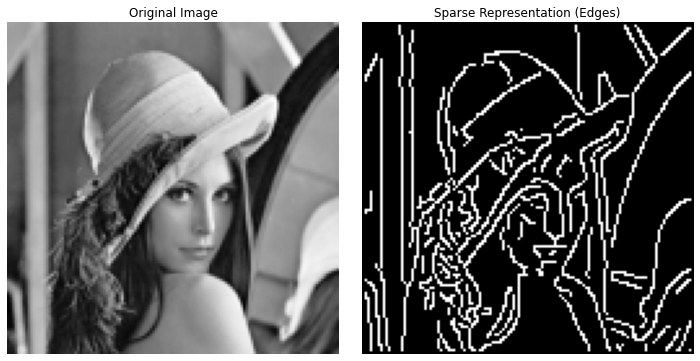

In [50]:
#  Load sample image
from skimage.transform import radon
import skimage as ski
lena_image = ski.io.imread("C:/Users/shash/Desktop/Courses2022_23/OptimizationandApplications_1/Project/lena.png")
lena_image = transform.resize(lena_image, (128, 128))
gray_image = ski.color.rgb2gray(lena_image)

# Edge detection to get a sparse representation
edges = feature.canny(gray_image)

# Visualize original and sparse representation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Sparse Representation (Edges)')
ax[1].axis('off')

plt.tight_layout()
plt.show()    

In [51]:
print(gray_image.shape, edges.shape)

(128, 128) (128, 128)


(128, 128)


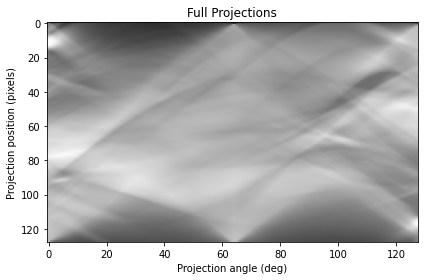

In [55]:
from skimage.transform import radon, iradon
import numpy as np

# Set of angles for the Radon transform
theta = np.linspace(0., 180., max(gray_image.shape), endpoint=False)

# Apply Radon transform to get projections
sinogram = radon(gray_image, theta=theta, circle=True)
print(sinogram.shape)

plt.imshow(sinogram, cmap='gray', aspect='auto')
plt.title('Full Projections')
plt.xlabel('Projection angle (deg)')
plt.ylabel('Projection position (pixels)')

plt.tight_layout()
plt.show()

In [61]:
total_rows = sinogram.shape[0]
random_indices = np.random.choice(total_rows, size=64, replace=False)  # Indices
sampled_sinogram = sinogram[random_indices, :].flatten()      # Selecting random rows from X_n
sampled_image = gray_image[random_indices,:].flatten()         # Selecting random rows from y_n
print(sampled_sinogram.shape, sampled_image.shape)

(8192,) (8192,)


In [ ]:
alpha_hat = cp.Variable(8192)

objective = cp.Minimize(cp.norm1(alpha_hat))

constraints = [sampled_image == sampled_sinogram @ alpha_hat ]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()
    
alpha_hat = alpha_hat.value

 choose $X$ to be the Radon transform. 

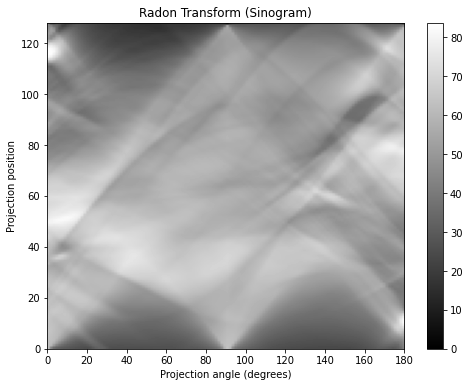

In [48]:
# Compute the Radon transform (sinogram) of the edge-detected image
theta = np.linspace(0., 180., max(edges.shape), endpoint=False)
sinogram = transform.radon(gray_image, theta=theta, circle=True)

# Visualize the sinogram
plt.figure(figsize=(8, 6))
plt.imshow(sinogram, cmap=plt.cm.gray, aspect='auto', extent=(0, 180, 0, sinogram.shape[0]))
plt.colorbar()
plt.title("Radon Transform (Sinogram)")
plt.xlabel("Projection angle (degrees)")
plt.ylabel("Projection position")
plt.show()

Now sample a submatrix of n rows of X and apply your solution to it.

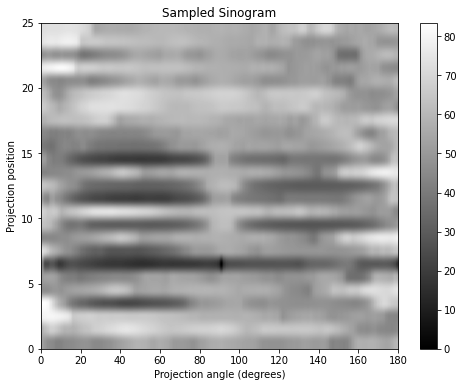

In [49]:
# Sample a subset of the sinogram to act as our compressed measurements
n_samples = int(sinogram.shape[0] * 0.2)  # Taking 20% of the rows for subsampling
sample_rows = np.random.choice(sinogram.shape[0], n_samples, replace=False)
sampled_sinogram = sinogram[sample_rows, :]
sampled_image = gray_image[sample_rows,:]

# Visualize the sampled sinogram
plt.figure(figsize=(8, 6))
plt.imshow(sampled_sinogram, cmap=plt.cm.gray, aspect='auto', extent=(0, 180, 0, sampled_sinogram.shape[0]))
plt.colorbar()
plt.title("Sampled Sinogram")
plt.xlabel("Projection angle (degrees)")
plt.ylabel("Projection position")
plt.show()

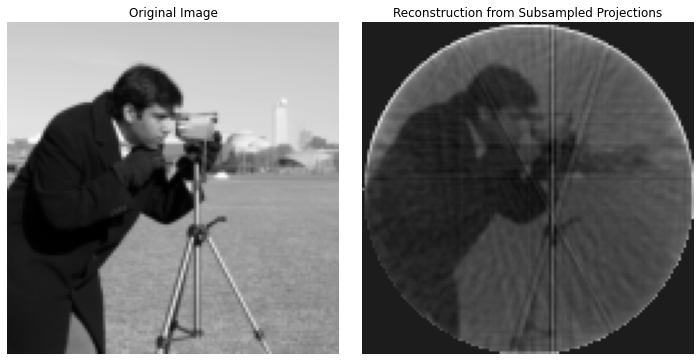

In [9]:
# Solving the minimization problem
alpha_hat = cp.Variable(N)

objective = cp.Minimize(cp.norm1(alpha_hat))

constraints = [y_n == X_n @ alpha_hat ]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()
    
alpha_hat = alpha_hat.value